# Demo de implementación de un algoritmo de Programación Genética ara resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios.
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


1) Importar librerías:

In [2]:
#@title
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image

import pickle
import codecs

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad de Poblaciones y Particulas en cada una para PG
CANT_LISTAS_POBLA_PARTICULAS = 3 #@param {type:"slider", min:1, max:5, step:1}
CANT_PARTICULAS = 5 #@param {type:"slider", min:1, max:10, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Inicializar objetos de DEAP para utilizar y especificar Primitivas, Estructura del Cromosoma + Función de Aptitud y Operadores Genéticos:

In [4]:
#@title clase MAPA DE BÚSQUEDA
Hash_configuracion_Mapa_Busqueda = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=" #@param {type:"string"}

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 

# si tiene la configuración definida, la carga sino crea nueva clase
if Hash_configuracion_Mapa_Busqueda != "":
  print("\n> Usando configuración de mapa de búsqueda definida en hash.")
  mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
else:
  # sino define el Mapa de Búsqueda nuevo
  print("\n> Creando nuevo mapa de búsqueda.")
  mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                      cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\n> Mapa de búsqueda definido:")
mapa.printInformacion()

print("\n> Hash del mapa de búsqueda definido: ")
print( codecs.encode(pickle.dumps(mapa), "base64").decode() )


Clase Mapa de Búqueda definida

> Usando configuración de mapa de búsqueda definida en hash.

> Mapa de búsqueda definido:

** Máximos Generados:  4
  --> [478, -112] {  96  } 
  --> [793, -127] {  98  } 
  --> [800, -746] {  33  } 
  --> [134, 522] {  29  } 

** Posición Máximo Óptimo:  [793, -127]  {  98  } **



> Hash del mapa de búsqueda definido: 
gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA
AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK
kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs
cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=



In [5]:
#@title clase PARTICULA para Programación Genética

class ParticulaPG(object):
    
    def __init__(self, mapa):        
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)        
        

    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos   


    def cambiarPosicion(self, nPos):
      if len(self.pos) == len(nPos):
        # cambia a la nueva posición indicada
        for i in range(len(self.pos)):    
          self.pos[i] = nPos[i]
      
      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAzar(self, distMaxima=100):
     
      for i in range(len(self.pos)):        
          # ajusta la posición de la partícula al azar
          ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
          if ajusteVel > distMaxima:
            ajusteVel = distMaxima
          self.pos[i] = self.pos[i] + int(ajusteVel)

          # revisa no haber superado los límites del mapa
          if self.pos[i] < self.mapa.limMin:
                self.pos[i] = self.mapa.limMin
          elif self.pos[i] > self.mapa.limMax:
                self.pos[i] = self.mapa.limMax

      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAtraido(self, mejorCiclo, coefAtraccMejorCiclo=1.5, distMaxima=100):
        
        for i in range(len(self.pos)):
            # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo
            ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
            ajusteVel = ajusteVel + (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i]))                       
            if ajusteVel > distMaxima:
              ajusteVel = distMaxima

            # ajusta la posición de la partícula 
            self.pos[i] = self.pos[i] + int(ajusteVel)

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)

        return self.pos

    def moverseAlrededor(self, mejorCiclo, radioMejor=100):
        
        for i in range(len(self.pos)):
            # ajusta posición dentro del radio de la mejor partícula
            self.pos[i] = random.randint(int(mejorCiclo.posicion[i]-radioMejor), int(mejorCiclo.posicion[i]+radioMejor)) 

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        
        return self.pos

print("\nClase ParticulaPG definida")

# Inicializa la lista de partículas (siempre la misma inicial)
listaPartPobla = []
for n in range(CANT_LISTAS_POBLA_PARTICULAS):
  auxPobla = []
  for i in range(CANT_PARTICULAS):
    p = ParticulaPG(mapa)
    auxPobla.append( p ) 
  print("\n", n, ") Lista de ParticulaPG con posiciones iniciales definida: ")
  for part in auxPobla:
    print(" ", part.posicion, " {", part.heuristica,"}")  
  listaPartPobla.append(auxPobla)


Clase ParticulaPG definida

 0 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [349, -974]  { 0 }
  [-214, -993]  { 0 }
  [-17, 60]  { 0 }
  [490, -354]  { 71.77 }
  [-381, 473]  { 0 }

 1 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [476, 125]  { 72.3 }
  [732, -59]  { 88.86 }
  [-866, 823]  { 0 }
  [724, -581]  { 14.83 }
  [-361, -591]  { 0 }

 2 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [-793, 635]  { 0 }
  [987, 788]  { 0 }
  [-425, 933]  { 0 }
  [-594, -714]  { 0 }
  [-880, -3]  { 0 }


In [6]:
#@title Inicializar valores de la librería DEAP

# Inicializa variables auxiliares para mostrar movimiento partículas
ciclosPos = []
registraPosHistorico = False

# función auxiliar para obtener la mejor partícula de una lista
def devuelveMejor(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la mejor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=True)
  mejorPart = rankingParticulas[0]
  return mejorPart

# función auxiliar para registrar posiciones de las particulas para mostrar
def registraPosParticulas(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return []
  auxLisPos = []
  for part in particulas:
    auxLisPos.append( copy.deepcopy( part.posicion ) )
  return auxLisPos

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## Define las primitivas a usar para ordenar la lista

def moverAzar(particulas, distMaxima):
  ## función tipo Mutación de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # mueve las partículas al azar
  for part in particulas:
    part.moverseAzar(distMaxima)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )  
  return particulas

def moverAzarFuncHeurist(particulas, distMaxima, mutate_factor=-2.5):
  ## función tipo HiperMutar de CLONALG
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # mueve las partículas al azar
  for part in particulas:
    # calcula distancia máxima en base a la heuristica
    distMaximaHeur = distMaxima * math.exp(mutate_factor * part.heuristica/100)
    if distMaximaHeur > 0:   
      part.moverseAzar(distMaximaHeur)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )  
  return particulas

def moverAtraidoAlMejor(particulas, porcAtraccMejorCiclo, distMaxima):
  ## función tipo PSO
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  if distMaxima <= 0:
    distMaxima = 1
  if porcAtraccMejorCiclo > 0:
    coefAtraccMejorCiclo = porcAtraccMejorCiclo/100.0
  else:
    coefAtraccMejorCiclo = 0.0
  # ajusta a todas en base a la mejor
  for part in particulas:
    part.moverseAtraido(mejorPart, coefAtraccMejorCiclo, distMaxima)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )  
  return particulas

def moverAlrededorMejor(particulas, radioMejor):
  ## función tipo Abejas
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if radioMejor <= 0:
    radioMejor = 1000     
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  # ajusta a todas en base a la mejor
  for part in particulas:
    part.moverseAlrededor(mejorPart, radioMejor)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )      
  return particulas

def intercambiarPos(particulas, porcCantIntercambios):
  ## función tipo Cruzamiento de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas  
  # toma particulas de a pares 
  # (primero y último, segundo y penúltimo,...)
  # teniendo en cuenta el máximo de cantIntercambios
  # e intercambia las posiciones
  mitadPart = len(particulas)//2
  cantIntercambios = porcCantIntercambios//100 * len(particulas)
  if cantIntercambios <= 0 or cantIntercambios > len(particulas):
    cantIntercambios = 2
  if mitadPart > cantIntercambios:
    mitadPart = cantIntercambios
  for part1, part2 in zip( particulas[:mitadPart:1], particulas[:mitadPart-1:-1] ):
      nPos1 = []
      nPos2 = []
      # intercambia las posiciones para posiciones impares
      for i in range(len(part1.posicion)):
        if (i%2)==0:          
          nPos1.append( part1.posicion[i] )
          nPos2.append( part2.posicion[i] )
        else:
          nPos2.append( part1.posicion[i] )
          nPos1.append( part2.posicion[i] )
      # indica las nuevas posiciones para las partículas
      # y actualiza la heurística
      part1.cambiarPosicion(nPos1)
      part2.cambiarPosicion(nPos2)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )      
  return particulas

def mejorHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la mejor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=True)
  mejorPart = rankingParticulas[0]
  return int(mejorPart.heuristica)

def promedioHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # calcula el promedio de la heuristica
  suma = 0.0
  for part in particulas:
    suma = suma + part.heuristica
  return int(suma/len(particulas))

def peorHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la peor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=False)
  mejorPart = rankingParticulas[0]
  return int(mejorPart.heuristica)

def pdiv(left, right):
    try:
        return int(left / right)
    except ZeroDivisionError:
        return 1

# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str, int], str) 
# para manejo de partículas
pset.addPrimitive(moverAzar, [str, int], str)
pset.addPrimitive(moverAzarFuncHeurist, [str, int], str)
pset.addPrimitive(moverAtraidoAlMejor, [str, int, int], str)
pset.addPrimitive(moverAlrededorMejor, [str, int], str)
pset.addPrimitive(intercambiarPos, [str, int], str)
pset.addPrimitive(mejorHeuristica, [str], int)
pset.addPrimitive(promedioHeuristica, [str], int)
pset.addPrimitive(peorHeuristica, [str], int)
# para manejo de parámetros
pset.addPrimitive(operator.add, [int, int], int)
pset.addPrimitive(operator.sub, [int, int], int)
pset.addPrimitive(operator.mul, [int, int], int)
pset.addPrimitive(pdiv, [int, int], int)
pset.addPrimitive(max, [int, int], int)
pset.addPrimitive(min, [int, int], int)  
#pset.addEphemeralConstant("rnd"+str(random.randint(0,100)), lambda: random.randint(0,150), int)

pset.renameArguments(ARG0='Particulas')
pset.renameArguments(ARG1='CantParts')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# función auxiliar para aplicar la expresión
def aplicaExpresion(individual, partPobla, debug=False):

  if debug: 
    print("\n")
    print(individual)

  # Transforma la expresión del árbol en una función que se puede ejecutar
  try:
    func = toolbox.compile(expr=individual)
  except MemoryError:
    # si tira error por BLOAT devuelve un error muy grande para descartarlo
    return -9999, [], [],

  # guarda el histórico de posiciones por cada ciclo
  # para luego usar para mostrar el mejor
  global ciclosPos
  global registraPosHistorico
  ciclosPos = []
  ciclosPos.append( registraPosParticulas(partPobla) )
  registraPosHistorico = True

  # ejecuta las primitiva del individuo
  partOptimizada =  func( copy.deepcopy( partPobla ), len(partPobla) )

  # determina la particula mejor ubicada 
  # al finalizar de evaluar el individuo
  mejorPart = devuelveMejor(partOptimizada)

  if debug: 
    # devuelve sólola mejor partícula
    print("Mejor Partícula: ", mejorPart.posicion, " { ", mejorPart.heuristica, " } ")

  # devuelve  la heurística de la mejor partícula, su posición y todas las generadas
  return mejorPart.heuristica, mejorPart.posicion, ciclosPos

# función auxiliar para calcular la aptitud
def calculaAptitud(individual):     
  
  # prueba con todas las lista de poblaciones de particulas
  # y devuelve el promedio de la heuristica 
  # con los resultados de la mejor "corrida"
  promHeur = 0.0
  todasMejorPos = []
  todasCiclosPos = []
  for partPobla in listaPartPobla:  
    # devuelve la heurística de la mejor partícula, su posición y todas las generadas
    auxHeur, auxPos, auxCiclosPos = aplicaExpresion(individual, partPobla, False)
    # calcula total heuristica par apromedio
    promHeur = promHeur + auxHeur
    # agrega mejor posicion
    todasMejorPos.append( auxPos )
    # agrega posiciones por ciclo unificado
    for i in range(len(auxCiclosPos)):
      if (len(todasCiclosPos)-1)<i:
        todasCiclosPos.append( [] )
      todasCiclosPos[i].extend( auxCiclosPos[i] )
  # calcula promedio
  promHeur = promHeur/len(listaPartPobla)
  # devuelve resultados
  return promHeur, todasMejorPos, todasCiclosPos

toolbox.register("evaluate", calculaAptitud)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


In [7]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [8]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  50#@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.5 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 25 #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 #@param {type:"slider", min:0, max:1, step:0.05}

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.5  #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [9]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    ciclosBestIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin

# vectores auxiliares 
ciclo = 1    
ciclosBestIndiv = []
ciclosBestIndivMejorPos = []
ciclosBestIndivCiclosPos = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []


# Muestra su información
mapa.printInformacion()

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
# notar que la función devuelve la heurística de la mejor partícula, su posición y todas las generadas
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit[0],

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=True)
auxIndiceBestInd = indivPobla.index( auxBestInd )
if auxIndiceBestInd >= 0:
  ciclosBestIndivMejorPos.append( fitnesses[auxIndiceBestInd][1] )
  ciclosBestIndivCiclosPos.append( fitnesses[auxIndiceBestInd][2] )
else:
  ciclosBestIndivMejorPos.append( [] )
  ciclosBestIndivCiclosPos.append( [] )


        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (auxMax > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            hijo1, hijo2 = toolbox.mate(hijo1, hijo2)
            #toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values
            
    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    aux_invalid_ind_fitnesses = []
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit[0],
        aux_invalid_ind_fitnesses.append(fit)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=True)
    if auxBestInd in invalid_ind:
      auxIndiceBestInd = invalid_ind.index( auxBestInd )
      if auxIndiceBestInd > 0:
          ciclosBestIndivMejorPos.append( aux_invalid_ind_fitnesses[auxIndiceBestInd][1] )
          ciclosBestIndivCiclosPos.append( aux_invalid_ind_fitnesses[auxIndiceBestInd][2] )
      else:
        ciclosBestIndivMejorPos.append( [] )
        ciclosBestIndivCiclosPos.append( [] )
    else:
        ciclosBestIndivMejorPos.append( [] )
        ciclosBestIndivCiclosPos.append( [] )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmax( ciclosMaxAptitud )

print("\n** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Individuo de la Corrida:", ciclosBestIndiv[mejorCiclo] )
print("   --> Mejores Posiciones Generadas: ", ciclosBestIndivMejorPos[mejorCiclo], " { ", ciclosMaxAptitud[mejorCiclo], " } ==")



** Máximos Generados:  4
  --> [478, -112] {  96  } 
  --> [793, -127] {  98  } 
  --> [800, -746] {  33  } 
  --> [134, 522] {  29  } 

** Posición Máximo Óptimo:  [793, -127]  {  98  } **



-- Ciclo  0 --
 Mejor Individuo: moverAzar(moverAzarFuncHeurist(Particulas, CantParts), mul(CantParts, CantParts))  { 58.33 }
   Max:  58.33  / Promedio:  49.91  / Min:  39.35

-- Ciclo  1 --
 Mejor Individuo: moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), peorHeuristica(Particulas))  { 65.19 }
   Max:  65.19  / Promedio:  52.86  / Min:  29.92

-- Ciclo  2 --
 Mejor Individuo: moverAzar(moverAlrededorMejor(Particulas, mejorHeuristica(Particulas)), mul(CantParts, CantParts))  { 74.15 }
   Max:  74.15  / Promedio:  50.68  / Min:  35.11

-- Ciclo  3 --
 Mejor Individuo: moverAlrededorMejor(moverAlrededorMejor(moverAzar(moverAtraidoAlMejor(Particulas, CantParts, CantParts), promedioHeuristica(Particulas)), CantParts), peorHeuristica(moverAtraidoAlMejor(Particulas, CantParts, CantPar

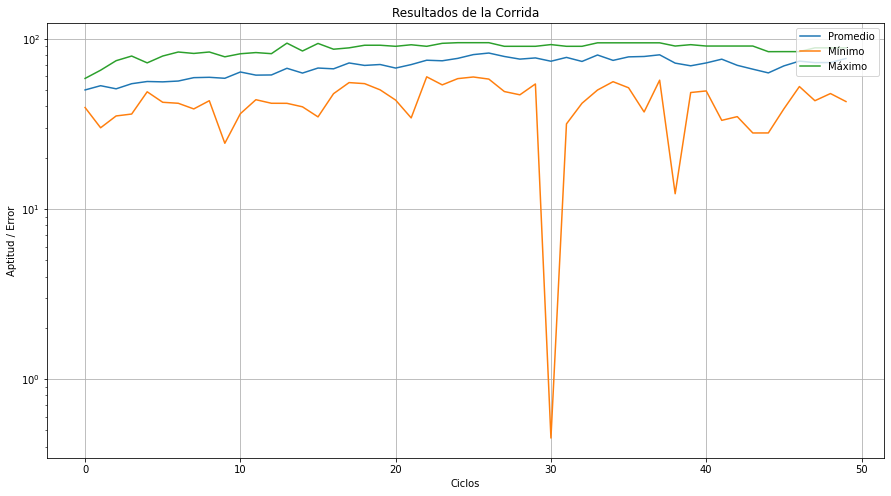

In [10]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.yscale('log')
plt.legend(['Promedio', 'Mínimo', 'Máximo'], loc='upper right')
plt.grid(True)

plt.show()

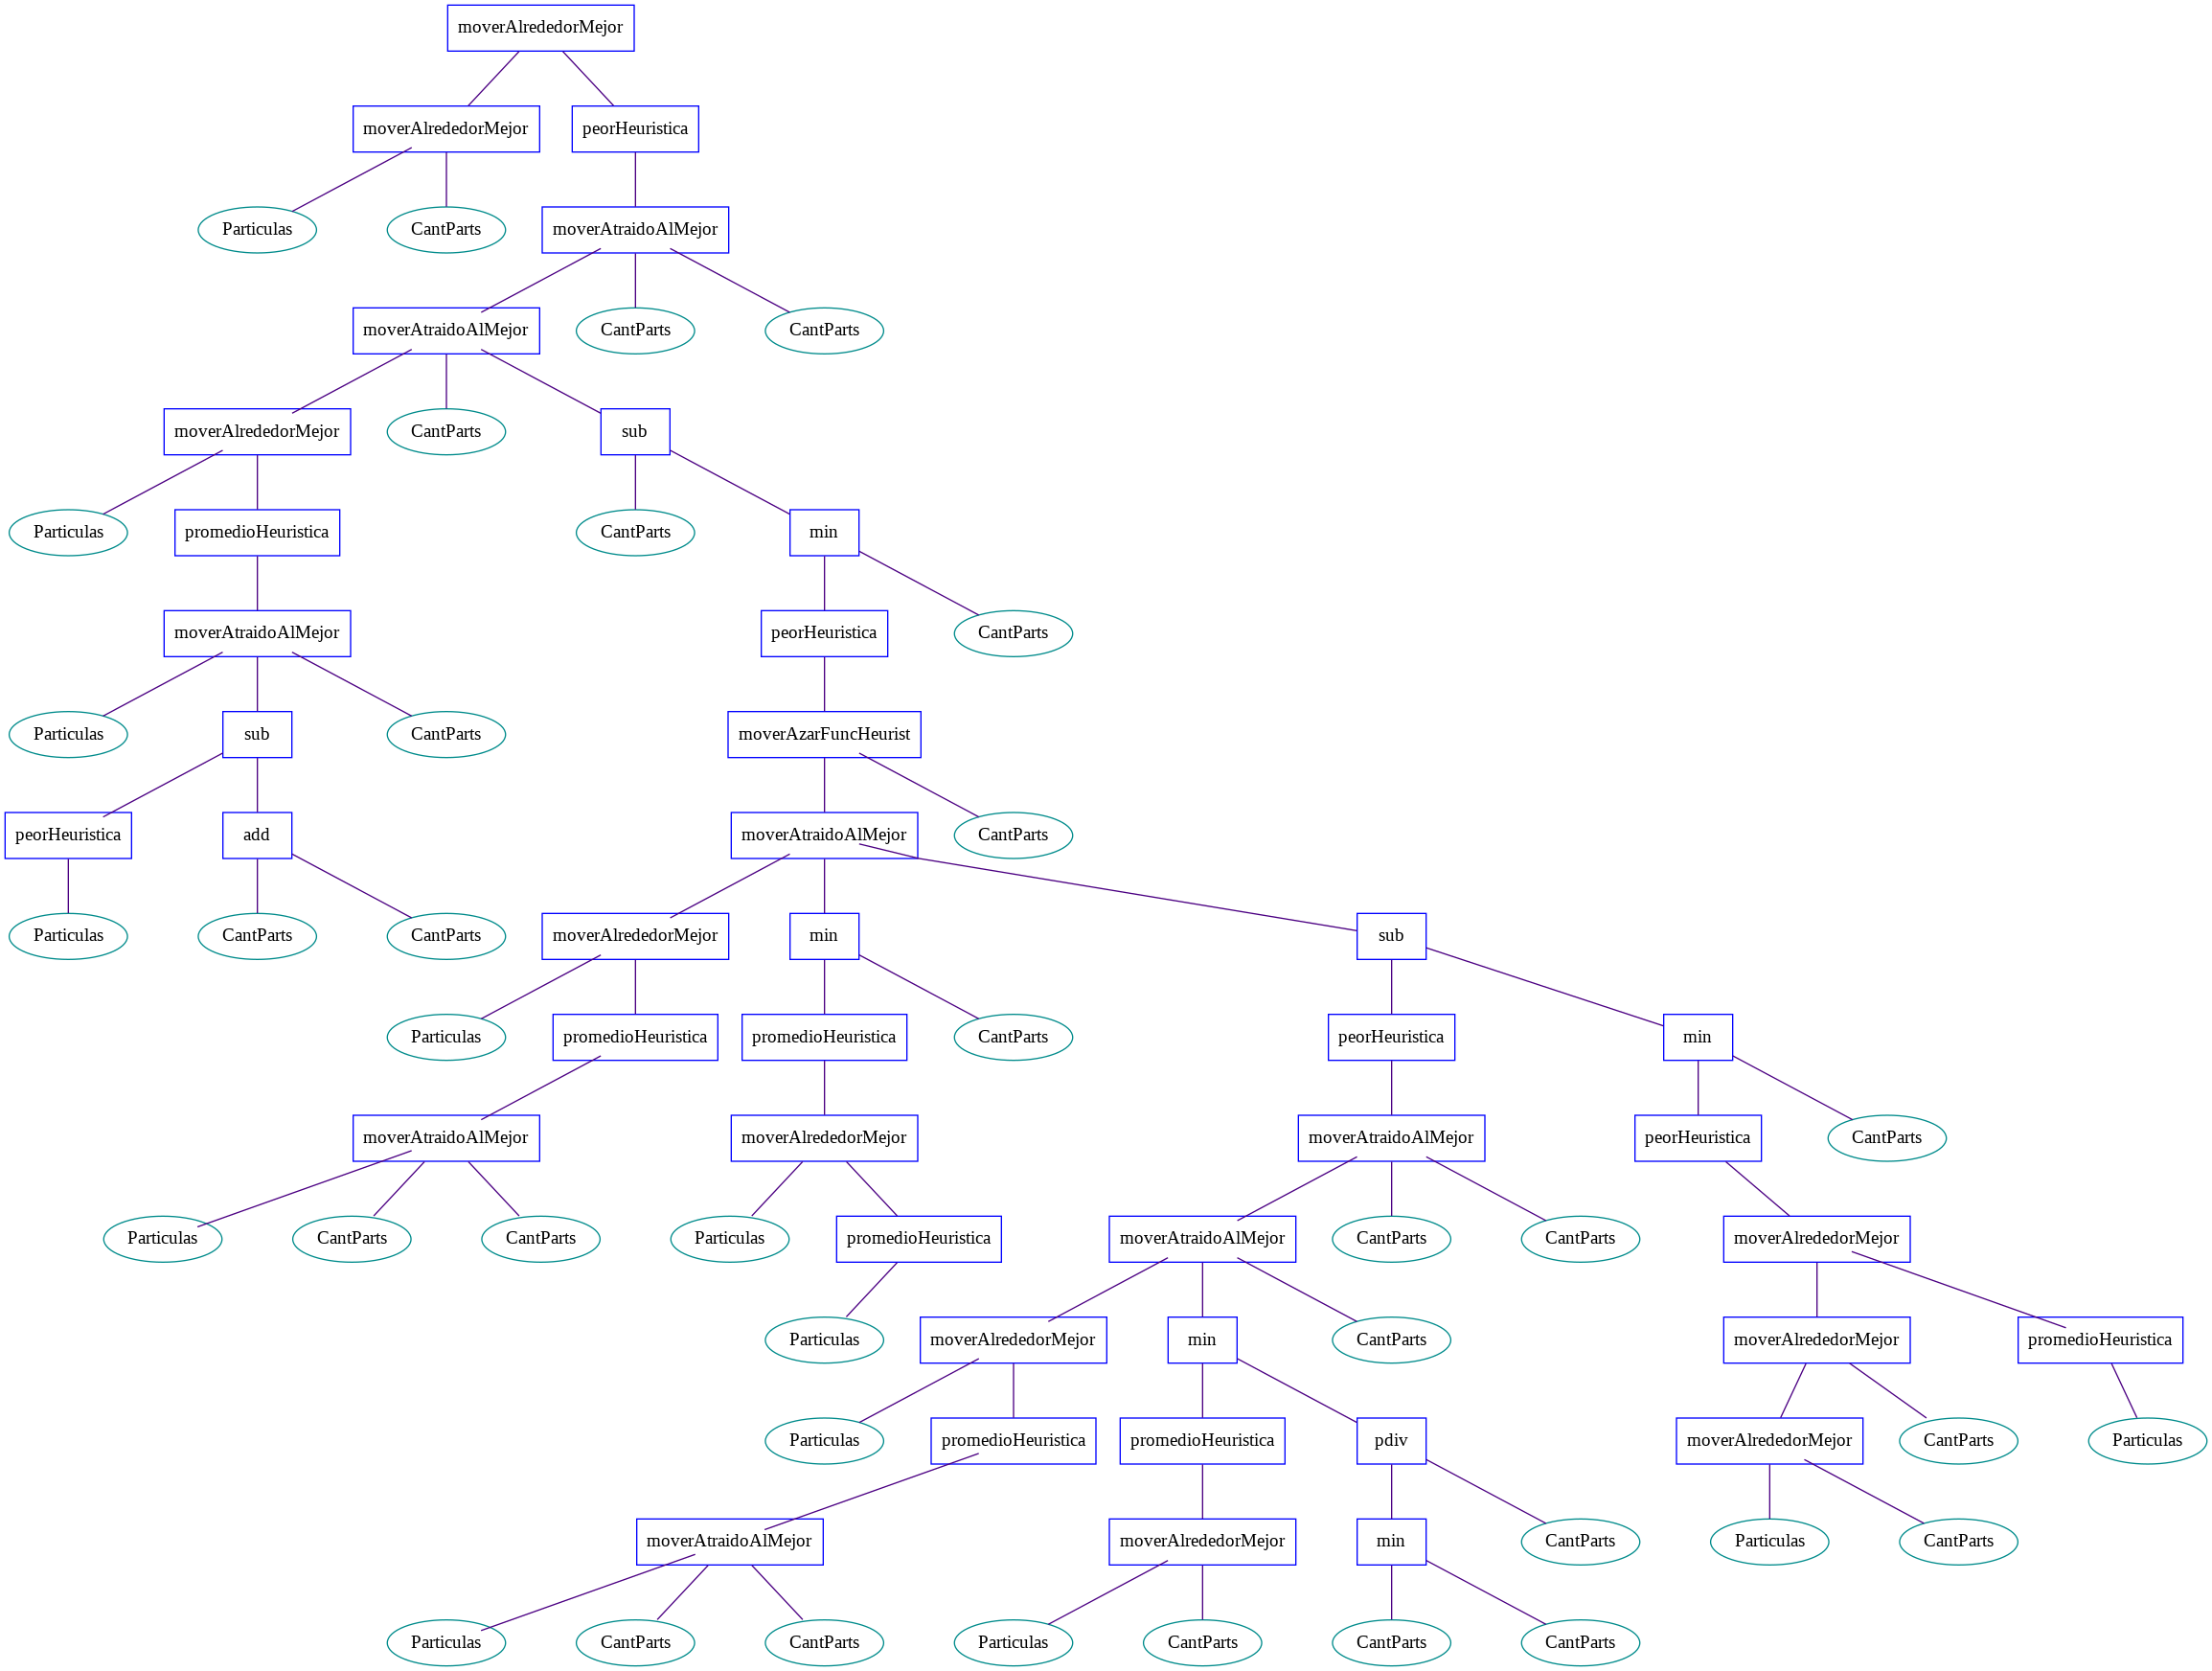


 moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), peorHeuristica(moverAtraidoAlMejor(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, sub(peorHeuristica(Particulas), add(CantParts, CantParts)), CantParts))), CantParts, sub(CantParts, min(peorHeuristica(moverAzarFuncHeurist(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, CantParts, CantParts))), min(promedioHeuristica(moverAlrededorMejor(Particulas, promedioHeuristica(Particulas))), CantParts), sub(peorHeuristica(moverAtraidoAlMejor(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, CantParts, CantParts))), min(promedioHeuristica(moverAlrededorMejor(Particulas, CantParts)), pdiv(min(CantParts, CantParts), CantParts)), CantParts), CantParts, CantParts)), min(peorHeuristica(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantPart

In [11]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN 
## CORRESPONDIENTE AL MEJOR INDIVIDUO 
nodes, edges, labels = gp.graph( ciclosBestIndiv[mejorCiclo] )

#g = pgv.AGraph()
g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles 
g.graph_attr['nodesep']='1.3' # separación en el mismo nivel

g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='CantParts' or labels[i]=='Particulas':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'    

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")

g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

print("\n", ciclosBestIndiv[mejorCiclo] )
print("   --> Mejores Posiciones Generadas: ", ciclosBestIndivMejorPos[mejorCiclo], " { ", ciclosMaxAptitud[mejorCiclo], " } ==")

print("\n> Mapa de búsqueda:")
mapa.printInformacion()


In [12]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LAS PARTICULAS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de las Partículas obtenidas de movimientos generados por PG"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejores Particulas: ' + str(ciclosBestIndivMejorPos[mejorCiclo]) + ' { ' + str(round(ciclosMaxAptitud[mejorCiclo], 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 
posMejorCorrida =  ciclosBestIndivMejorPos[mejorCiclo]
ax = None
ani = None

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat):

        if ax==None or ciclosPos==None:
            return scat,

        ax.set_xlabel('Operación: ' + str(i), fontsize=12)

          # Si no es el último ciclo, muestra también el global
        if i<len(ciclosPos): 
        
          if len(ciclosPos[i])>0:
             
              if MOSTRAR_HISTORICO_MOVIMIENTO:
                  # Coloca nuevas posiciones correspondientes al ciclo
                  # Separa las coordenadas x, y de las posiciones en el ciclo i
                  X, Y = zip(*ciclosPos[i])
                  ## --en Rojo: posiciones de las particulas de cada ciclo
                  scat = ax.scatter(X, Y, color='red')
              else:
                  # Hace mover a las Partículas
                  scat.set_offsets(ciclosPos[i])
        else:
               if posMejorCorrida != None:
                 ## --en Violeta: Mejor posición de las partículas
                if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
                    ax.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
                else:
                    X, Y = zip(*posMejorCorrida)                      
                    ax.scatter(X, Y, color='violet', s=100)

        # Devuelve una lista de "artistas" para dibujar, 
        # en este caso es sólo uno por lo que se pone una coma final
        return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, textoTitulo="", textoDesc=""):          
      
      fig = plt.figure(figsize=(14,7))
      ax = fig.add_subplot(111)
      plt.close()

      ## -- en Azul: Máximos Locales (positivos)
      ## -- en Cyan: Mínimos Locales (negativos)
      ## -- en Verde: Máximo Óptimo
      for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
        if vali < 0:
            ax.scatter(posi[0], posi[1], color='cyan')
        else:
            ax.scatter(posi[0], posi[1], color='blue')
      ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

      # Define el tamaño de la figura
      ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

      # Separa las coordenadas x, y de las posiciones en el ciclo inicial
      X, Y = zip(*ciclosPos[0])
      ## --en Rojo: posiciones de las posiciones de cada ciclo
      scat = ax.scatter(X, Y, color='red')

      # Muestra título y texto debajo
      ax.set_title(textoTitulo)
      ax.set_ylabel(textoDesc, fontsize=11)

      # Luego setea la animación usando los dos métodos anteriores 
      cant = len(ciclosPos)+1
      ani = animation.FuncAnimation(fig, updatePlot, 
                                    frames=cant, interval=cant,
                                    fargs=(ciclosPos, scat), 
                                    blit=True, repeat=False)
      
      return ani, ax
    
# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosBestIndivCiclosPos[mejorCiclo], textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
ani


In [13]:
#@title PRUEBA CON OTROS VALORES INICIALES DE PARTICULAS - GRAFICO DE POSICIONES DE LAS PARTICULAS CICLO x CICLO
print("\n", ciclosBestIndiv[mejorCiclo] )

# inicializa otras partículas
partPobla2 = []
for i in range(CANT_PARTICULAS):
  p = ParticulaPG(mapa)
  partPobla2.append( p ) 
print("\nLista de NUEVAS ParticulaPG con posiciones iniciales definida: ")
for part in partPobla2:
   print(" ", part.posicion, " {", part.heuristica,"}")  

# aplica el individuo
mejorHeuristica2, posMejorCorrida2,  ciclosPos2 = aplicaExpresion(ciclosBestIndiv[mejorCiclo] , partPobla2, True)
print("\n\n")

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de NUEVAS Partículas obtenidas de movimientos generados por PG"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejores Particulas: ' + str(posMejorCorrida2) + ' { ' + str(round(mejorHeuristica2, 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 
posMejorCorrida =  posMejorCorrida2
ax = None
ani = None

# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos2, textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
ani


 moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), peorHeuristica(moverAtraidoAlMejor(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, sub(peorHeuristica(Particulas), add(CantParts, CantParts)), CantParts))), CantParts, sub(CantParts, min(peorHeuristica(moverAzarFuncHeurist(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, CantParts, CantParts))), min(promedioHeuristica(moverAlrededorMejor(Particulas, promedioHeuristica(Particulas))), CantParts), sub(peorHeuristica(moverAtraidoAlMejor(moverAtraidoAlMejor(moverAlrededorMejor(Particulas, promedioHeuristica(moverAtraidoAlMejor(Particulas, CantParts, CantParts))), min(promedioHeuristica(moverAlrededorMejor(Particulas, CantParts)), pdiv(min(CantParts, CantParts), CantParts)), CantParts), CantParts, CantParts)), min(peorHeuristica(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantPart